<div style="background-color: #f0f2f5; padding: 20px; border-radius: 10px; border-left: 10px solid #20beff;">
    <h1 style="color: #1c1c1c; margin-bottom: 5px;">生徒のテスト点数予測：🇯🇵日本語学習者のためのシンプルなアンサンブル入門</h1>
    <p style="color: #666;">経済学の視点を取り入れた特徴量設計とその検証</p>
</div>

**アンサンブル学習の挙動を理解するために作成しました！アドバイスなどあればコメントいただけると嬉しいです！**

**🏗️ Data Flow & Strategy:**

線形による下書き (Ridge Stacking): RidgeCV を用いて線形的な相関を抽出し、その予測値を「メタ特徴量」として後続のモデルへ供給しています。

厳密なターゲットエンコーディング: SmoothingとFold分割を併用し、リークを排したカテゴリ数値化を実施しています。

モデル別・配膳システム:

XGBoost / LightGBM: 標準化 + OneHot + TE を施した「加工されたデータ」を供給。

CatBoost: 独自の内部処理を活かすため、あえて加工を最小限に抑えた「生の文字列データ」を供給。

三本の矢（Blending）: 性格の異なる3つのブースティングモデル（王道のXGB、爆速のLGBM、カテゴリ特化のCat）をアンサンブルし、予測の分散を抑制。

「どのモデルに、どのタイミングで、どのデータを食べさせるか」という、前処理の分岐（Data Flow）の設計に注力しました。Catの精度は比較的低いですが、頑健性のために比率はそこまで下げずにアンサンブルしました。

In [36]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [37]:
# ----------------------------------------------------------------
# コラム名の正規化関数
# ----------------------------------------------------------------
def normalize_columns(df):
    """
    コラム名の空白をアンダースコアに置換し、小文字化するための関数。重複コラムも削除。
    """
    df.columns = [c.replace(' ', '_').strip().lower() for c in df.columns] #replaceでアンダースコアに変換、stripで両端の空白を除去、lowerで小文字化
    return df.loc[:, ~df.columns.duplicated()] #コラム名をチェックして、2回目以降の重複名に True、初めて出た名前に False を返す（ティルダで反転することで、重複を切り捨てる）

# ----------------------------------------------------------------
# データの読み込み
# ----------------------------------------------------------------
# ※ Kaggle環境で実行する場合はパスを "/kaggle/input/..." に書き換えてください
trn_df = pd.read_csv("playground-series-s6e1/train.csv") #あとで元データと結合しtrainとするため、今はtrnとつける
test_df = pd.read_csv("playground-series-s6e1/test.csv")
orig_df = pd.read_csv("playground-series-s6e1/StudentPerformanceFactors.csv") #コンペの元データ

# 全データフレームを一括で正規化
trn_df = normalize_columns(trn_df)
test_df = normalize_columns(test_df)
orig_df = normalize_columns(orig_df)

rename_map = {
    'hours_studied': 'study_hours',
    'attendance': 'class_attendance',
}
orig_df = orig_df.rename(columns=rename_map) #マッピングを用いて一括変換

# 元データの、カテゴリ値の表記ゆれ（大文字小文字）を統一
# 元データでは maleが Maleなど、一文字目が大文字になっています
cat_cols = ['gender', 'internet_access']
for col in cat_cols:
    for df in [trn_df, test_df, orig_df]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower()

# ----------------------------------------------------------------
# 順序変数のエンコーディング (Ordinal Encoding)
# ----------------------------------------------------------------
ordinal_maps = {
    "sleep_quality": {"poor": 0, "average": 1, "good": 2},
    "facility_rating": {"low": 0, "medium": 1, "high": 2},
    "exam_difficulty": {"easy": 0, "moderate": 1, "hard": 2},
    "internet_access": {"no": 0, "yes": 1}
}

for df in [trn_df, test_df, orig_df]:
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            # 元の値を活かしつつ、計算用の数値コラムを追加
            df[f"{col.split('_')[0]}_num"] = df[col].map(mapping)

# ----------------------------------------------------------------
# データの結合
# ----------------------------------------------------------------
# データの出自（どれがオリジナルか）を区別するフラグを追加
trn_df['is_original'] = 0
orig_df['is_original'] = 1
test_df['is_original'] = 0 #エラーが出ないようにtestにもコラムを追加

# 元データの共通のコラムのみを抽出して結合
common_cols = list(set(trn_df.columns) & set(orig_df.columns))
train_df = pd.concat([trn_df, orig_df[common_cols]], axis=0, ignore_index=True) #axis=0は、行方向（縦方向）に繋げるという意味

valid_split = 0.15
seed = 42 #DSの中の慣習？

print(f"Combined Train Shape: {train_df.shape}")

Combined Train Shape: (636607, 18)


In [38]:
def make_features(df):

    # 学習時間が多い（7時間以上）かどうか
    df['high_study'] = (df['study_hours'] >= 7).astype(int)

    df['study_sleep_power'] = df['study_hours'] * df['sleep_num']
    df['mental_margin']     = df['sleep_hours'] - df['exam_num']
    df['active_hours']      = 24 - df['sleep_hours']
    df['free_time']         = df['active_hours'] - df['study_hours']
    df['study_ratio']       = df['study_hours'] / df['active_hours']
    df["fatigue"]           = (df["study_hours"] + df["class_attendance"]) / df["sleep_hours"]
    df["focus"]             = df["study_hours"] / (df["internet_num"] + 1)
    df["rest_efficiency"]   = df["sleep_num"] / (df["study_hours"] + 1)
    df["env_advantage"]     = df["facility_num"] * df["internet_num"]

    df['study_hours_sq'] = df['study_hours'] ** 2
    df['log_study_hours'] = np.log1p(df['study_hours']) 
    df['class_attendance_sq'] = df['class_attendance'] ** 2
    df['log_class_attendance'] = np.log1p(df['class_attendance'])
    df['study_hours_cubed'] = df['study_hours'] ** 3

    return df
    
train_df = make_features(train_df)
test_df = make_features(test_df)

# ----------------------------------------------------------------
# ターゲットエンコーディング (SmoothingとCross-Validation適用版)
# ----------------------------------------------------------------
# Smoothingと交差検証を併用することで厳格にLeakageを防ぎます
def target_encode_smooth(df, col, target, m=20):
    """
    データの少ないカテゴリが極端な値にならないよう、全体平均に寄せる(Smoothing)処理
    普通のTEでは、極端な値（受けたのが1人しかいないけどその1人がたまたま超優秀だった授業とか）に対して過学習するので、そのグループのデータが少ない場合は、そのグループではなく全体の平均を適用する
    """
    global_mean = df[target].mean() #全体平均
    stats = df.groupby(col)[target].agg(['mean','count'])

    # Smoothing公式: (カテゴリ平均 * カウント + 全体平均 * m) / (カウント + m), m:どれくらい慎重になるかを表すハイパーパラメータ
    # countが自グループを表す。自グループのデータ数が多い場合は自分の平均に近づき、小さい場合はmと全体平均に比重づけが行われる
    # この場合はm＝20なので、20までの大きさのグループであれば、全体平均も大きな比重を持つことになる
    smooth = (stats['count'] * stats['mean'] + m * global_mean) / (stats['count'] + m)
    return smooth

# Leakageを防ぐための交差検証(Cross-Validation, CV)を用いたターゲットエンコーディング
# この場合、データを5分割したのち、自分以外のデータ群の平均値を使うことで、「自分のグループの正解」を見ることがなくなる
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
overall_mean = train_df['exam_score'].mean() #欠損値補完用の全体平均

for col in ["course", "study_method"]:
    new_col = f"{col}_te"
    train_df[new_col] = 0

    # Leakage（リーク）防止のため、Foldごとにエンコーディングを計算
    for tr_idx, val_idx in kf.split(train_df): #データ分割した上でForループで一気に処理する
        smooth_map = target_encode_smooth(
            train_df.iloc[tr_idx], col, "exam_score", m=20
        )
        train_df.loc[val_idx, new_col] = train_df.loc[val_idx, col].map(smooth_map) #ここでSmoothing、5分割した上でさらに外れ値の影響を除去
        
    # 欠損値は全体平均で補完
    train_df[new_col] = train_df[new_col].fillna(overall_mean)

    # テストデータ用には、学習データ全体から作成したマップを適用（エラー防止に意味のない同じ列を追加する）
    smooth_map = target_encode_smooth(train_df, col, "exam_score", m=20)
    test_df[new_col] = test_df[col].map(smooth_map).fillna(overall_mean)

train_df['env_synergy'] = train_df['course_te'] * train_df['facility_num']
test_df['env_synergy'] = test_df['course_te'] * test_df['facility_num']

In [39]:
numerical_cols = [
    "feature_lr_pred",
    "high_study",
    'study_hours_sq',
    'log_study_hours',
    'class_attendance_sq',
    'log_class_attendance',
    "focus",
    "free_time",
    "course_te",
    "class_attendance",
    "study_sleep_power", 
    "study_method_te", 
    "facility_num", 
    "env_synergy", 
    "mental_margin",
    "fatigue",
    "rest_efficiency",
    "env_advantage",
    "sleep_hours", 
    "study_hours"
    ]

nominal_cols = ["gender", "internet_access"]

# ---Ridge（線形モデル）による下書き生成 ---
# OLSに「係数の2乗」という重り（罰則）を加え、過学習を防ぐ手法
# OLSは残差2乗和を最小化するが、多重共線性や外れ値が生じた際に係数を極端に大きくしてエラーをなくそうとしがち、その係数すら最小化するようにモデルを組む
# alphas=[...] はハイパーパラメータ λ (ラムダ) の候補。λ＝0であれば通常のOLSと一緒
# RidgeCVが、その中から一番精度の高いλを自動で選んでくれる
ridge_features = [
    'study_hours', 'class_attendance', 
    'study_hours_sq', 'class_attendance_sq',
    'course_te', 'study_method_te',
    'facility_num', 'sleep_num'
]

# 欠損値を訓練データの平均で一括補完（分散の過小評価に注意だが実装優先）
all_fill_cols = list(set(numerical_cols + ridge_features))
for col in all_fill_cols:
    if col in train_df.columns:
        fill_mean = train_df[col].mean()
        train_df[col] = train_df[col].fillna(fill_mean)
        test_df[col] = test_df[col].fillna(fill_mean)

# 線形モデルの予測値を「新たな特徴量」として追加する手法（Stackingの基礎）
# 線形の関係に対してはOLS的な手法の方が精度が高いことが多く、それを特徴料として組み込む
# cross_val_predictを使うことで「自分のデータで学習した結果で自分を予測する」リークを防ぐ
scaler_ridge = StandardScaler() # 線形モデルは単位が違うと学習しづらくなるので、標準化する
X_ridge = scaler_ridge.fit_transform(train_df[ridge_features])
X_test_ridge = scaler_ridge.transform(test_df[ridge_features])
y = train_df['exam_score']

ridge = RidgeCV(alphas =[0.1, 1.0, 10.0, 100.0]) #モデルを定義、計量ではλ（ラムダ）だが、DSではα
train_df['feature_lr_pred'] = cross_val_predict(ridge, X_ridge, y, cv=5) #交差検証はcross_val_predictに内包されている機能、交差検証にすることでLeakageを予防

# テストデータ用には全学習データで再学習したモデルを使う
# トレインデータは、Leakageを防ぐためデータをわざと隠すが、テストデータはそもそも値を知らないので、全てのデータを学習させた最強Ridgeを作る
ridge.fit(X_ridge, y)
test_df['feature_lr_pred'] = ridge.predict(test_df[ridge_features])

# ---メインモデル（XGBoost等）用のデータセット作成 ---
# 不要なカラム（計算用の一時変数や、既に数値化した元カテゴリ変数）を一括削除
drop_list = [
    "id", "age", "exam_num", "internet_num", "study_method", "course", "study_ratio", 
    "exam_score", "sleep_quality", "facility_rating", "exam_difficulty"
]
final_drop = [c for c in drop_list if c in train_df.columns] #ミスってコラム内にdrop_listが存在しな買った時のエラー防止策

# Cat用に、「削除前」の train_df で分割を行い、そのあとで各モデル用に配る
X_Cat = train_df.drop(["id", "exam_score"], axis=1) # 最小限の削除だけ
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_Cat, y, test_size=valid_split, random_state=seed)

X = train_df.drop(final_drop, axis=1)
X_test = test_df.drop([c for c in final_drop if c != "exam_score"], axis=1)

# モデルを鍛える「訓練用」と、実力を試す「検証用」に分割
# valid_split（0.15など）の割合で「未知のデータ（検証用）」を疑似的に作る
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=valid_split, random_state=seed
)

print(f"特徴量数: {X_train.shape[1]}")

特徴量数: 26


In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_cols), # ridgeで作った特徴量も標準化、他の特徴量に対しては一回標準化しているので、平均が0分散が1のデータ群となり、結果は変わらない
        ("nom", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), nominal_cols) #drop="first"(最初にできた特徴量を削除)することで、強い多重共線性を防ぐ
    ],
    remainder="drop",
)

X_train_pre = preprocessor.fit_transform(X_train)
X_valid_pre = preprocessor.transform(X_valid)

In [41]:
model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=seed,
    early_stopping_rounds=100,
    n_jobs=-1,
    verbosity=0,
)

model.fit(
    X_train_pre, y_train,
    eval_set=[(X_valid_pre, y_valid)],
    verbose=200
    )

preds = model.predict(X_valid_pre)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print(f"XGBoost RMSE: {rmse}")

[0]	validation_0-rmse:18.06761
[200]	validation_0-rmse:8.74929
[400]	validation_0-rmse:8.71978
[600]	validation_0-rmse:8.70406
[800]	validation_0-rmse:8.69464
[1000]	validation_0-rmse:8.68945
[1200]	validation_0-rmse:8.68593
[1400]	validation_0-rmse:8.68308
[1600]	validation_0-rmse:8.68236
[1601]	validation_0-rmse:8.68231
XGBoost RMSE: 8.681576467686229


In [42]:
# カテゴリ変数のリストを指定（元のカラム名）
# Catはカテゴリ変数に強く、こちらがTEやOneHotで加工して渡すより生データを渡したほうが学習する
cat_features = ["gender", "internet_access", "sleep_quality", "facility_rating", "exam_difficulty", "course","study_method"]

# 1. CatBoostに「余計なヒント」を与えないための削除リスト
# TE系の列と、手動で数値化した _num 系の列を両方リストアップ
redundant_cols = [c for c in X_train.columns if c.endswith('_te') or c.endswith('_num')]

# 2. CatBoost専用のデータセット作成（余計な加工をしていないすっぴん DataFrame）
X_train_cb = X_train_raw.drop(columns=redundant_cols)
X_valid_cb = X_valid_raw.drop(columns=redundant_cols)

# 文字列型に変換（これで KeyError は出ない！）
for col in cat_features:
    X_train_cb[col] = X_train_cb[col].astype(str)
    X_valid_cb[col] = X_valid_cb[col].astype(str)

cb_model = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.01,
    depth=6,
    loss_function='RMSE',
    random_seed=seed,
    verbose=200,
    early_stopping_rounds=100
)

cb_model.fit(
    X_train_cb, y_train,
    cat_features=cat_features, # ここが最重要！
    eval_set=(X_valid_cb, y_valid),
    use_best_model=True
)

cb_preds = cb_model.predict(X_valid_cb)
cb_rmse = np.sqrt(mean_squared_error(y_valid, cb_preds))

print(f"CatBoost RMSE: {cb_rmse}")

0:	learn: 18.6981131	test: 18.6536740	best: 18.6536740 (0)	total: 154ms	remaining: 12m 48s
200:	learn: 9.3135841	test: 9.2835447	best: 9.2835447 (200)	total: 40.6s	remaining: 16m 8s
400:	learn: 8.8821752	test: 8.8670864	best: 8.8670864 (400)	total: 1m 13s	remaining: 13m 59s
600:	learn: 8.8405608	test: 8.8293219	best: 8.8293219 (600)	total: 1m 47s	remaining: 13m 6s
800:	learn: 8.8255419	test: 8.8162234	best: 8.8162234 (800)	total: 2m 27s	remaining: 12m 51s
1000:	learn: 8.8152904	test: 8.8076465	best: 8.8076465 (1000)	total: 3m	remaining: 12m 1s
1200:	learn: 8.8071219	test: 8.8009509	best: 8.8009509 (1200)	total: 3m 34s	remaining: 11m 18s
1400:	learn: 8.7989784	test: 8.7941676	best: 8.7941676 (1400)	total: 4m 8s	remaining: 10m 38s
1600:	learn: 8.7909095	test: 8.7876062	best: 8.7876062 (1600)	total: 4m 42s	remaining: 9m 59s
1800:	learn: 8.7837704	test: 8.7820734	best: 8.7820734 (1800)	total: 5m 18s	remaining: 9m 25s
2000:	learn: 8.7774851	test: 8.7773054	best: 8.7773054 (2000)	total: 5m 5

**LightGBMが「早い・強い」と言われる3つの理由**

XGBoostの後発としてMicrosoftが開発したこのモデルは、数理的にかなり賢いサボり方をしている。

Leaf-wise（葉ごとの成長）: 普通の木モデル（XGB等）は「1段ずつ（Level-wise）」成長するが、LightGBMは「一番誤差が減りそうな葉っぱ」をピンポイントで伸ばす。これにより、少ない回数で一気に正解に辿り着けます。

GOSS（勾配ベースの片側サンプリング）: 「すでにうまく予測できているデータ」は無視して、「まだ誤差が大きいデータ」を重点的に学習します。全部のデータを見ないので爆速。これらの特徴により、過学習は招きやすいが、「使えそうな枝葉に集中すること」で試行回数を減らしても精度を上げることができている

EFB（排他的特徴量束）: 「めったに一緒に登場しない変数」同士を1つにまとめてしまう技術。変数の数が実質的に減るので、メモリを食わない。

In [43]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    num_leaves=31, #「木の複雑さ」を決める。2の（max_depth）乗より少し小さく設定するのが定石。今回は、2**5=32なので31
    random_state=seed,
    importance_type='gain',
    early_stopping_rounds=100
)

lgb_model.fit(
    X_train_pre, y_train,
    eval_set=[(X_valid_pre, y_valid)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), 
        lgb.log_evaluation(period=200)]
)

lgb_preds = lgb_model.predict(X_valid_pre)
lgb_rmse = np.sqrt(mean_squared_error(y_valid, lgb_preds))

print(f"LightGBM RMSE: {lgb_rmse}")

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 541115, number of used features: 23
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 62.544207
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 76.7793
[400]	valid_0's l2: 76.3622
[600]	valid_0's l2: 76.0879
[800]	valid_0's l2: 75.9337
[1000]	valid_0's l2: 75.8298
[1200]	valid_0's l2: 75.7388
[1400]	valid_0's l2: 75.6

In [44]:
final_ensemble_preds = (preds * 0.35) + (cb_preds * 0.30) + (lgb_preds * 0.35)

ensemble_rmse = np.sqrt(mean_squared_error(y_valid, final_ensemble_preds))
print(f"三本の矢アンサンブル RMSE: {ensemble_rmse}")

三本の矢アンサンブル RMSE: 8.681033965780163


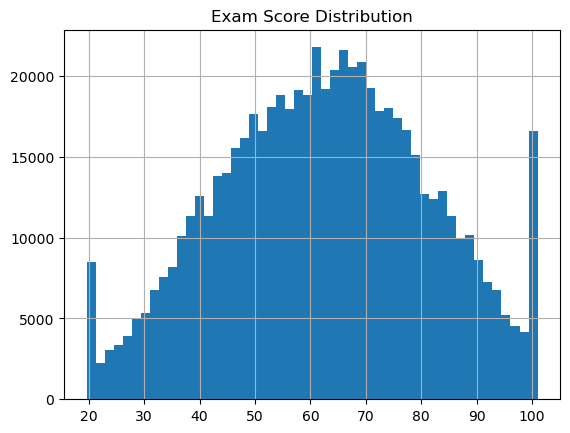

exam_score              1.000000
feature_lr_pred         0.760005
log_study_hours         0.715846
study_ratio             0.640735
study_hours             0.629403
focus                   0.577468
study_sleep_power       0.559375
high_study              0.440659
class_attendance        0.361551
log_class_attendance    0.361205
class_attendance_sq     0.357723
study_hours_sq          0.297433
sleep_num               0.236766
study_method_te         0.223681
env_synergy             0.188174
facility_num            0.188057
fatigue                 0.178064
env_advantage           0.169468
sleep_hours             0.166605
mental_margin           0.153348
study_hours_cubed       0.102463
is_original             0.025454
course_te               0.016897
age                     0.010472
exam_num                0.008773
internet_num            0.000597
id                      0.000372
active_hours           -0.166605
rest_efficiency        -0.213191
free_time              -0.616906
Name: exam

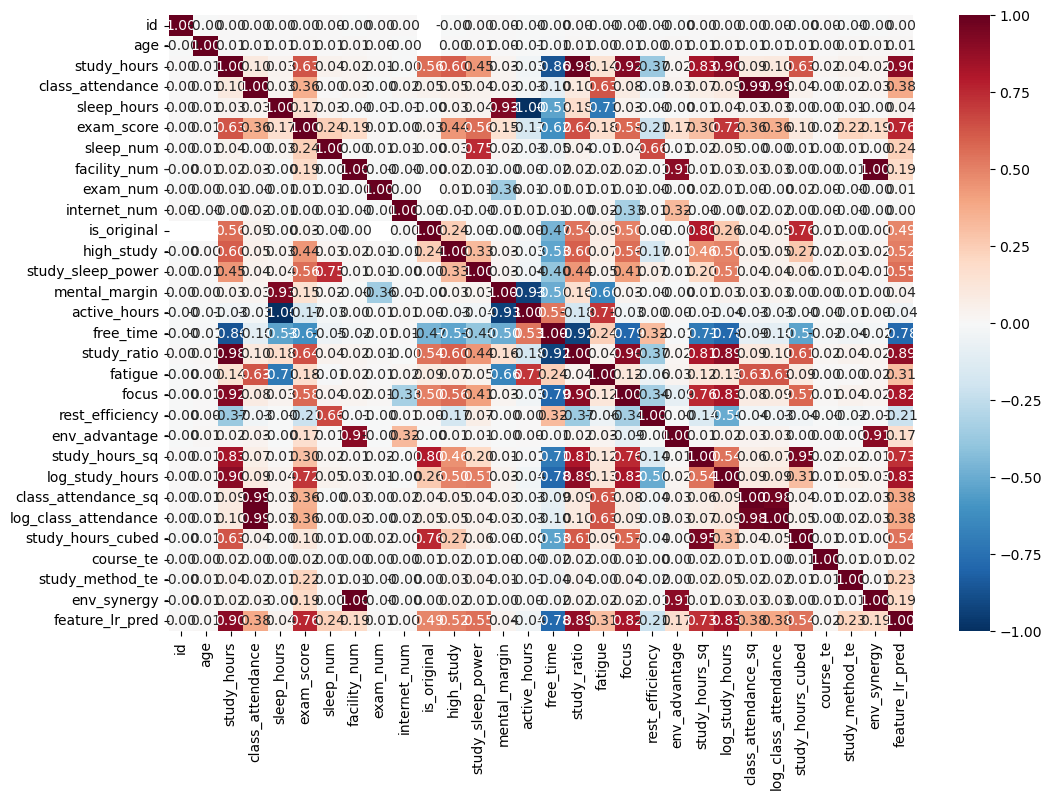

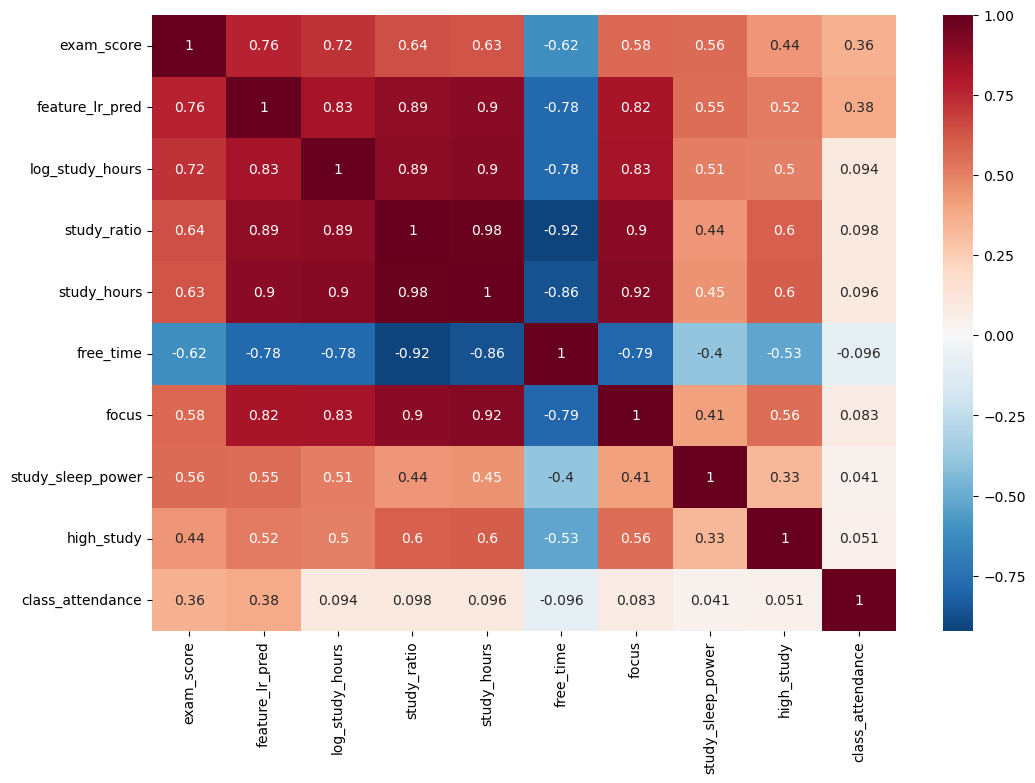

,gender,study_hours,class_attendance,internet_access,sleep_hours,sleep_num,facility_num,is_original,high_study,study_sleep_power,...,env_advantage,study_hours_sq,log_study_hours,class_attendance_sq,log_class_attendance,study_hours_cubed,course_te,study_method_te,env_synergy,feature_lr_pred
613957,female,0.08,97.0,yes,5.0,0.0,2.0,0,0,0.00,...,2.0,0.0064,0.076961,9409.00,4.584967,0.000512,62.547327,69.265129,125.094655,52.293988
526766,other,1.01,72.9,no,9.3,1.0,1.0,0,0,1.01,...,0.0,1.0201,0.698135,5314.41,4.302713,1.030301,62.270250,65.098077,62.270250,47.776806
236686,male,2.02,80.0,yes,8.2,1.0,2.0,0,0,2.02,...,2.0,4.0804,1.105257,6400.00,4.394449,8.242408,62.504144,65.098077,125.008287,60.326198
629254,other,6.10,54.5,yes,6.3,0.0,2.0,0,0,0.00,...,2.0,37.2100,1.960095,2970.25,4.016383,226.981000,62.513492,57.661806,125.026984,64.314407
573761,male,4.94,63.8,yes,7.9,0.0,2.0,0,0,0.00,...,2.0,24.4036,1.781709,4070.44,4.171306,120.553784,62.504144,57.661806,125.008287,60.727545


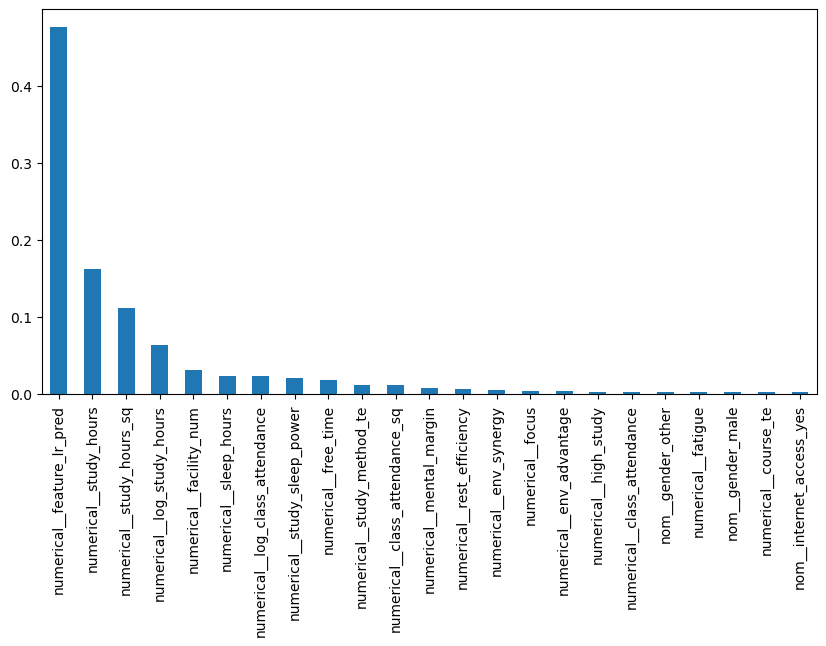

In [45]:
train_df['exam_score'].hist(bins=50)
plt.title("Exam Score Distribution")
plt.show()

X_train.head()

correlations = train_df.select_dtypes(include=[np.number]).corr()['exam_score'].sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(12, 8))
sns.heatmap(train_df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='RdBu_r', fmt='.2f')
plt.show()

top_corr_cols = train_df.corr(numeric_only=True)['exam_score'].abs().sort_values(ascending=False).head(10).index
top_corr_matrix = train_df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

importances = pd.Series(model.feature_importances_, index=preprocessor.get_feature_names_out())
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))

diff = np.abs(y_valid - final_ensemble_preds)
X_valid.loc[diff.sort_values(ascending=False).index].head(5)

In [48]:
X_test_pre = preprocessor.transform(test_df)

# CatBoost用（訓練時と同じく redundant_cols を落とす）
X_test_cb = test_df.drop(columns=redundant_cols)
for col in cat_features:
    X_test_cb[col] = X_test_cb[col].astype(str)
# 訓練時と同じ列順序であることを保証
X_test_cb = X_test_cb[X_train_cb.columns]

xgb_test_preds = model.predict(X_test)
cb_test_preds = cb_model.predict(X_test_cb)
lgb_test_preds = lgb_model.predict(X_test)

final_ensemble_preds = (xgb_test_preds * 0.35) + (cb_test_preds * 0.30) + (lgb_test_preds * 0.35)

sub_df = pd.DataFrame({"id": test_df.id, "exam_score": final_ensemble_preds})
sub_df.to_csv("submission.csv", index=False)